# Deep Probabilistice Generative Models - Final Project - VAE for Mnist
\- By Jiangnan HUANG & You ZUO

In [70]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import dataset_loader
import random

%matplotlib inline

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

# the dataset contains 3 splits (train/dev/test),
# each one containing two vectors (pixels and classes)
(train_data_pixels, train_data_classes), \
(dev_data_pixels, dev_data_classes), _ = dataset_loader.load_mnist(mnist_path)

In [4]:
# dataset_loader return numpy tensors,
# we convert them directly to pytorch tensors
train_data_pixels = torch.from_numpy(train_data_pixels).float()
train_data_classes = torch.from_numpy(train_data_classes).long()

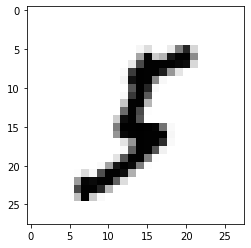

In [6]:
def display_images(images):
    # convert to numpy tensor
    images = images.detach().numpy()

    for i in range(images.shape[0]):
        plt.imshow(images[i].reshape(28,28), cmap='Greys')
        plt.show()
        
# display the first image in the dataset
display_images(train_data_pixels[:1])


In [12]:
def KL_with_gaussian_prior(mu, log_sigma_squared):
    
    KL = -(1/2)* torch.sum(1 + log_sigma_squared - mu**2 - torch.exp(log_sigma_squared),dim=1)
    
    return KL

In [29]:
class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.proj1_1 = nn.Linear(input_dim, hidden_dim)
        self.proj1_2 = nn.Linear(hidden_dim, hidden_dim)
        self.proj2_1 = nn.Linear(hidden_dim, output_dim)
        self.proj2_2 = nn.Linear(hidden_dim, output_dim)
                
        
    def forward(self, batch):

        hid = self.proj1_1(batch)
        hid = F.relu(hid)
        hid = self.proj1_2(hid)
        hid = F.relu(hid)
                
        return (self.proj2_1(hid),self.proj2_2(hid))

In [110]:
class GaussianPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        
        self.input_dim = input_dim
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, hidden_dim)
        self.proj3 = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, batch):
        
        hid = self.proj1(batch)
        hid = F.relu(hid)
        hid = self.proj2(hid)
        hid = F.relu(hid)
        hid = self.proj3(hid)
        
        return torch.sigmoid(hid)

    
    def sample_distributions(self, n_samples):
        # first sample from the prior,
        # then pass the data through this network
        
        # shape of z: (n_samples, input_dim)
        z = torch.empty(n_samples, self.input_dim)
        z = z.normal_()
        z = self(z)
        
        return z
        
        
    # sample images
    def sample_images(self, n_samples, sample=False):
        # compute the output distributions for each image
        # probs shape: (n_samples, output_dim)
        means = self.sample_distributions(n_samples)

        samples = means
        
        if sample:
            
            samples = torch.normal(means,0.1)
            
            zero = torch.zeros_like(samples)
            one = torch.ones_like(samples)
            
            # if the sampled value is bigger than 1 or smaller than 0, reset it by 1 or 0.
            samples = torch.where(samples < 0, zero, samples)
            samples = torch.where(samples > 1, one, samples)
            
            
        return samples

In [111]:
dim_input = 28*28 # size of input images
latent_dim = 2    # we use only 2 dimensions so we can plot them!
hidden_dim = 256  # size of hidden layer

n_epoch = 20      
batch_dim = 256

train_data = train_data_pixels

encoder = GaussianEncoder(dim_input, hidden_dim, latent_dim)
decoder = GaussianPriorDecoder(latent_dim, hidden_dim, dim_input)


optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0

    decoder.train()
    encoder.train()
    for i in range(0, train_data.shape[0], batch_dim): 
        optimizer.zero_grad()
        
        batch = train_data[i:i+batch_dim]
        
        # compute parameters of the approximate posterior
        mu, log_sigma_squared = encoder(batch)

        # the reparameterization trick

        e = torch.empty_like(mu).normal_(mean=0.,std=1.)
        z = e*(torch.sqrt(torch.exp(log_sigma_squared))) + mu
        

        reconstruction = decoder(z)
        reconstruction_loss = nn.MSELoss(reduction="none" ) # use mean square error loss
        kl_div = KL_with_gaussian_prior(mu, log_sigma_squared)

        elbo = -reconstruction_loss(reconstruction,batch).sum(1) - kl_div
        
        epoch_reconstruction += reconstruction_loss(reconstruction,batch).sum().item()
        epoch_kl += kl_div.sum().item()
        
        # we want to maximize the ELBO,
        # but Pytorch does minimization,
        # so we define our loss as -ELBO
        # and we mean over instances in the dataset
        loss = -elbo.mean()
        loss.backward()
        
        
        # gradient clipping, so we don't take too big updates
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        
        optimizer.step()
        
    print(
        epoch, ":\t",
        epoch_reconstruction / train_data.shape[0],
        "\t",
        epoch_kl / train_data.shape[0]
    )

0 :	 53.48571826171875 	 1.6470613589614629
1 :	 40.248102666015626 	 3.056219508666992
2 :	 37.87012326171875 	 3.480566851806641
3 :	 36.42581193359375 	 3.755961101074219
4 :	 35.2782057421875 	 3.9906644635009765
5 :	 34.42689567382813 	 4.175940087280273
6 :	 33.77046861328125 	 4.332327881469727
7 :	 33.235463662109375 	 4.42572447265625
8 :	 32.81821166015625 	 4.522034683227539
9 :	 32.43832178710937 	 4.592122878417968
10 :	 32.1731393359375 	 4.643588448486328
11 :	 31.90653494140625 	 4.706056646118164
12 :	 31.653065356445314 	 4.764655244750976
13 :	 31.459273764648437 	 4.788043820800781
14 :	 31.270821103515626 	 4.83246223022461
15 :	 31.139183837890624 	 4.864925259399414
16 :	 30.935158173828125 	 4.901042587280274
17 :	 30.775871577148436 	 4.943419274902344
18 :	 30.648168159179686 	 4.95778250793457
19 :	 30.55011646484375 	 4.984603880004883


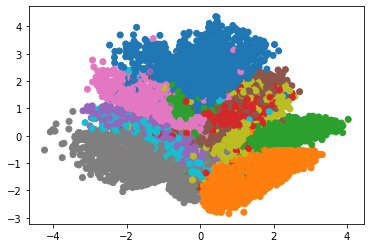

In [112]:
decoder.eval()

# tensor that will contain all latent points
points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim]
        mu,sigma = encoder(batch)
        points[i:i+batch_dim] = mu.numpy()+np.sqrt(np.exp(sigma.numpy()))


plt.scatter(
    points[:,0], points[:, 1],
    # colormap is between 0 and 1, and we have 10 classes
    # so we just divide by 10 :)
    # https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
    c=matplotlib.cm.get_cmap("tab10")(train_data_classes / 10.)
)
plt.show()

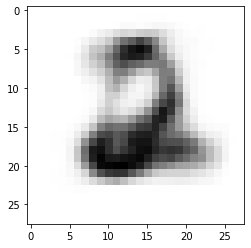

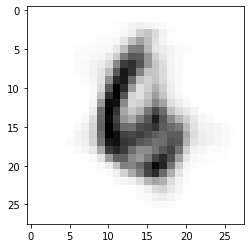

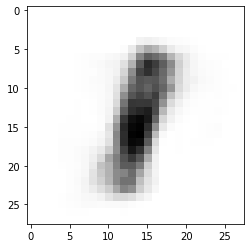

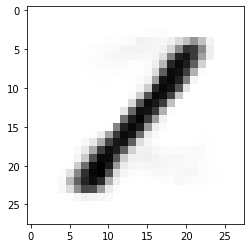

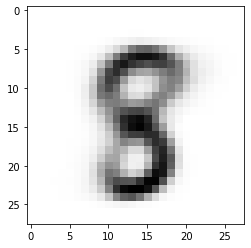

In [113]:
decoder.eval()

with torch.no_grad():
    # try means values
    samples = decoder.sample_images(5,sample=False)
    display_images(samples)
    plt.show()

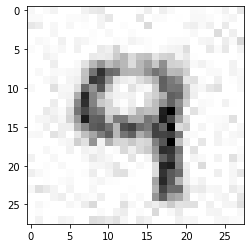

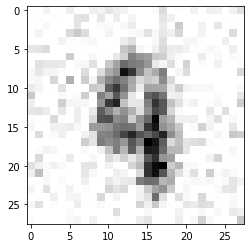

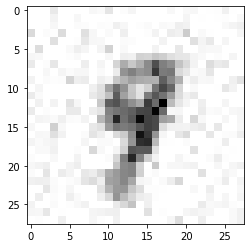

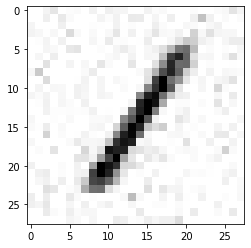

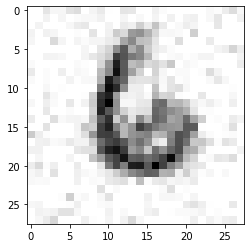

In [114]:
decoder.eval()

with torch.no_grad():
    # try sample from gaussian distributions
    samples = decoder.sample_images(5,sample=True)
    display_images(samples)
    plt.show()

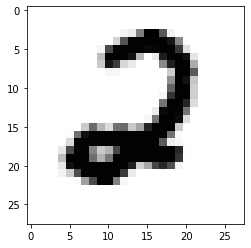

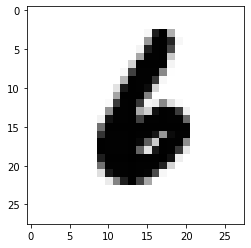

In [127]:
# randomly select 2 images
digits_index = np.random.choice(train_data_pixels.numpy().shape[0],2)
display_images(train_data_pixels[digits_index])

In [128]:
# compute the posterior
mean_a,_ = encoder(train_data_pixels[digits_index[0]])
mean_b,_ = encoder(train_data_pixels[digits_index[1]])

In [129]:
# try to interpolate with different convex combinations of these two means
epsilon = torch.arange(0, 1.1, 0.05)
latent_values = epsilon.reshape(-1, 1) * mean_a + (1 - epsilon.reshape(-1, 1)) * mean_b

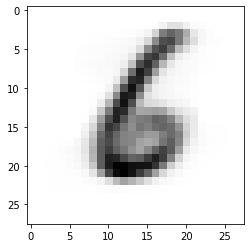

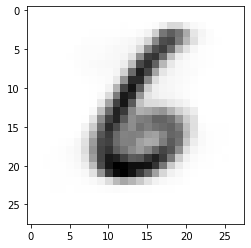

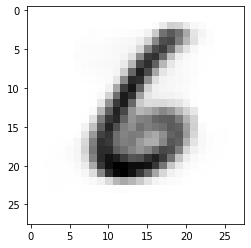

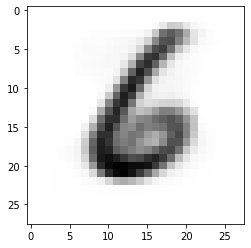

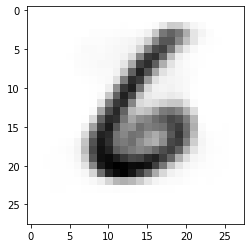

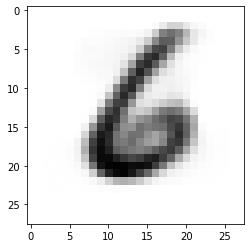

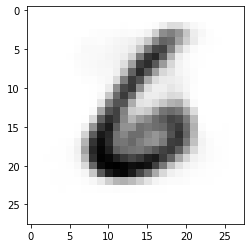

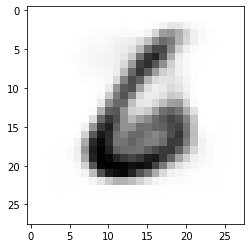

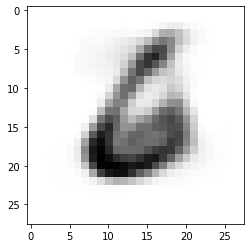

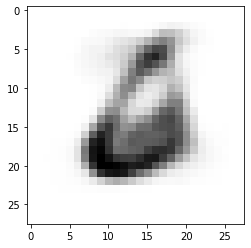

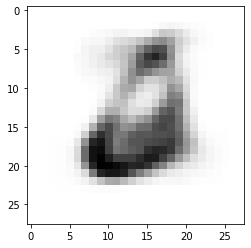

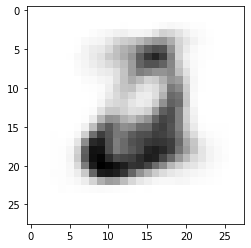

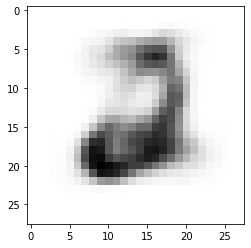

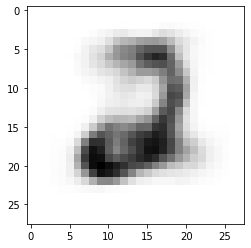

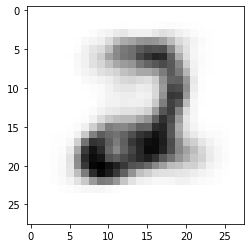

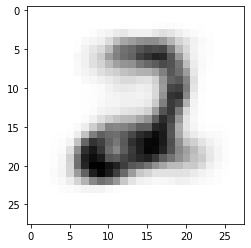

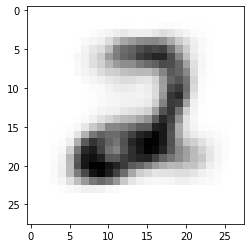

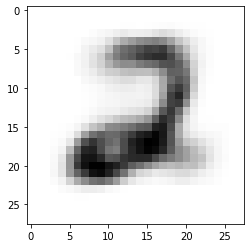

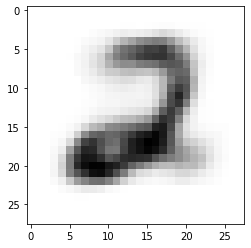

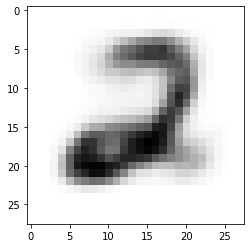

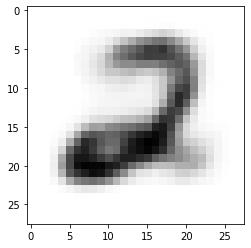

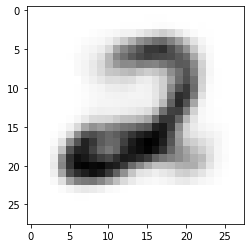

In [130]:
decoder.eval()

with torch.no_grad():
    # plot the results
    samples = decoder(latent_values)
    display_images(samples)
    plt.show()